# Frequency of topics using NGRAMS -  NLS -  Encyclopaedia Britannica


The key here is to have a look at what we are getting with the track of each individual series - by plotting  the mention of each topic term over time - giving them each individual term a line in the graph. So we can see if the argument changes over time, and certain things trend at certain times.

We have started with the following topics, to see how each of topic's terms become more popular: 
 
- Sports: golf, rugby, tennis, football, shinty, real tennis, bowls,lawn bowls, garden bowls
- Scottish cities: Aberdeen, Dundee, Edinburgh, Glasgow, Stirling, Inverness, Perth
- Scottish philosophers: Francis Hutcheson, David Hume, Adam Smith, Dugald Stewart, Thomas Reid
- Random animal fun option: cat, dog, kitten, puppy, goldfish, parrot

For getting the counts of each term  we have run the following several defoe queries. And just to facilitate things, we have developed 4 methods for doing so:

  1) Running all the queries at once: This implies to read (and preprocess) the data just once from XMLs files, and later perform all the desired queries.
     - spark-submit --py-files defoe.zip defoe/run_queries.py nls_updated.txt nls -l query_distributed_topics.txt -n 16
         
     Note: Inside query_distributed_topics.txt we have all the queries that we want to run.  
            
 2) Running all the queries individually: This implies to read (and preprocess) the data from XMLs files for each query to run.
 
     - spark-submit --py-files defoe.zip defoe/run_query.py nls_updated.txt nls defoe.nls.queries.keysearch_by_year queries/sc_philosophers.yml -r results_ks_philosophers -n 16
     - spark-submit --py-files defoe.zip defoe/run_query.py nls_updated.txt nls defoe.nls.queries.keysearch_by_year queries/sc_cities.yml -r results_ks_cities -n 16 
     - spark-submit --py-files defoe.zip defoe/run_query.py nls_updated.txt nls defoe.nls.queries.keysearch_by_year queries/animal.yml -r results_ks_animal -n 16 
     - spark-submit --py-files defoe.zip defoe/run_query.py nls_updated.txt nls defoe.nls.queries.keysearch_by_year queries/sport.yml -r results_ks_sports -n 16
        
 3) Running all the queries using ES: This means to run individually each query reading each time the preprocessed data we have previously ingested (with another defoe query) in ElasticSearch.
    
    - spark-submit --driver-class-path elasticsearch-hadoop-7.5.0/dist/elasticsearch-hadoop-7.5.0.jar --jars elasticsearch-hadoop-7.5.0/dist/elasticsearch-hadoop-7.5.0.jar --py-files defoe.zip defoe/run_query.py es_data_edina_updated.txt es defoe.es.queries.keysearch_by_year queries/sport.yml  -r results_ks_sports -n 16
        
4) Running all the queries at once using ES: This means to read only once the preprocessed data we have previously ingested (with another defoe query) in ElasticSearch, and run later all the queries.
    
    - spark-submit --driver-class-path elasticsearch-hadoop-7.5.0/dist/elasticsearch-hadoop-7.5.0.jar --jars elasticsearch-hadoop-7.5.0/dist/elasticsearch-hadoop-7.5.0.jar --py-files defoe.zip defoe/run_queries.py es_data_edina_updated.txt es -l query_distributed_topics_es.txt -n 16
        
     Note: Inside query_distributed_topics_es.txt we have all the queries that we want to run.  

Users, can decide which method they prefer. They will obtain the same results independently of the method that they have chosen. 

The results of are stored in this gitHub, inside the folder called results_NLS.

Futhermore, we also needed to run the normalised query, to know how many documents, pages and words we have per year of eddition. 

* spark-submit --py-files defoe.zip defoe/run_query.py nls_updated.txt nls defoe.nls.queries.normalize -r results_nls_normalized -n 324 


Note: nls_updated.txt contains the path of all downloaded dataset:

    xxx/nls-data-encyclopaediaBritannica/193108323
    xxx/nls-data-encyclopaediaBritannica/193696080
    xxx/nls-data-encyclopaediaBritannica/144850378
    xxx/nls-data-encyclopaediaBritannica/191253839
    etc ....


### Loading the necessary libraries

In [1]:
import yaml
import matplotlib.pyplot as plt
import numpy as np
import collections

### Functions

In [2]:
def freq_count(results):
    freq_count={}
    for year in results:
        for i in results[year]:
            if i[0] not in freq_count:
                freq_count[i[0]]={}
                freq_count[i[0]][year]=i[1]
                
            else:
                if year not in freq_count[i[0]]:
                    freq_count[i[0]][year]=i[1]
                else:    
                    freq_count[i[0]][year]+=i[1]
    return freq_count

In [3]:
def normalize_freq(publication, freq_results, view_terms):
    plt.figure(figsize=(16,6))
    years=set()
    for term in view_terms:
        if term in freq_results:
            normed_results = {}
            for year in freq_results[term]:
                if year>0:
                    normed_results[year] = (freq_results[term][year]* len(term.split()))/float(publication[year][2])
                    years.add(year)
            plt.plot(*zip(*sorted(normed_results.items())), label=term, lw = 2, alpha = 1, marker="X")
    plt.xticks(sorted(list(years)), rotation=50)
    plt.ticklabel_format(style = 'plain')
    plt.legend(loc='upper right')
    plt.xlabel("Years")
    plt.ylabel("Normalized Frequency")
    plt.show()       

In [4]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [5]:
def plot_freq_count(freq_results, view_terms):
    plt.figure(figsize=(18,6))
    years=set()
    for term in view_terms:
        if term in freq_results:
            plt.plot(*zip(*sorted(freq_results[term].items())), label=term, lw = 2, alpha = 1, marker="X")
            for y in freq_results[term].keys(): 
                years.add(y)     
    plt.xticks(sorted(list(years)), rotation=50)
    plt.ticklabel_format(style = 'plain')
    plt.legend(loc='upper right')
    plt.ylabel('Frequency')
    plt.xlabel("Years")
    plt.show()

In [6]:
def plot_norm(publication, element):
    plt.figure(figsize=(18,6))
    num_element={}
    years=set()
    for year in publication:
        if element == "words":
            num_element[year]=publication[year][2]
        elif element == "pages":
            num_element[year]=publication[year][1]
        else:
            num_element[year]=publication[year][0]
        years.add(year)  
    plt.plot(*zip(*sorted(num_element.items())), label=element, lw = 2, alpha = 1, marker="X")
    plt.xticks(sorted(list(years)), rotation=50) 
    plt.ticklabel_format(style = 'plain')
    plt.legend(loc='upper right')
    plt.ylabel('Number of ' + element + 'per volumne')
    plt.xlabel("Years")
    plt.show()
    return num_element, years

In [7]:
# Plot two lines with different scales on the same plot
def cumulative_plot(element1, element2, num_element1, num_element2, years):
    fig = plt.figure(figsize=(12, 6))
    line_weight = 3
    alpha = .5
    ax1 = fig.add_axes([0, 0, 1, 1])
    ax1.set_xticks(sorted(list(years))) 
    ax2 = fig.add_axes()# This is the magic that joins the x-axis
    ax2 = ax1.twinx()
    lns1 = ax1.plot(*zip(*sorted(num_element1.items())), color='blue', lw=line_weight, alpha=alpha, label=element1, marker='d')
    lns2 = ax2.plot(*zip(*sorted(num_element2.items())), color='orange', lw=line_weight, alpha=alpha, label=element2, marker='s')
    leg = lns1 + lns2
    labs = [l.get_label() for l in leg]
    ax1.legend(leg, labs, loc=0)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=50 )
    plt.title('Cumulative yearly '+ element1 +' & '+ element2)  
    plt.show()

## 1. Normalised Query

First we examine the total number of documents, pages and words published over the period to see how much our search terms are affected by the way that published increases over the measurement period.

The query return the results in this format:

    {
      <YEAR>: [<NUM_DOCUMENTS>, <NUM_PAGES>, <NUM_WORDS>],
      ...
    }

In [8]:
norm_publication=read_query_results('results_nls_normalized')

#for printing the values, we are going to sort the values by the years. 
#e.g --> First: 1771 year, with 3 documents, 2722 pages, and 2587557 words. 
#e.g --> Last: 1853 year, with 22 documents , 19628 pages and 23475295 words.

sorted(norm_publication.items())

[(1771, [3, 2722, 2587557]),
 (1773, [3, 2740, 2581066]),
 (1778, [10, 9448, 10218591]),
 (1797, [11, 9512, 10495573]),
 (1801, [2, 1740, 1943036]),
 (1803, [2, 1760, 1956641]),
 (1810, [40, 17662, 18876327]),
 (1815, [20, 17470, 18764604]),
 (1823, [20, 17546, 18742386]),
 (1824, [15, 13436, 12258062]),
 (1842, [22, 19532, 22407301]),
 (1853, [22, 19628, 23475295])]

In order to set the scene and visualize how the documents, pages and words grew over the time, we are going to plot three basic graphs:        
- number of documents over time per year
- number of pages over time per year
- number of words over time per year
      

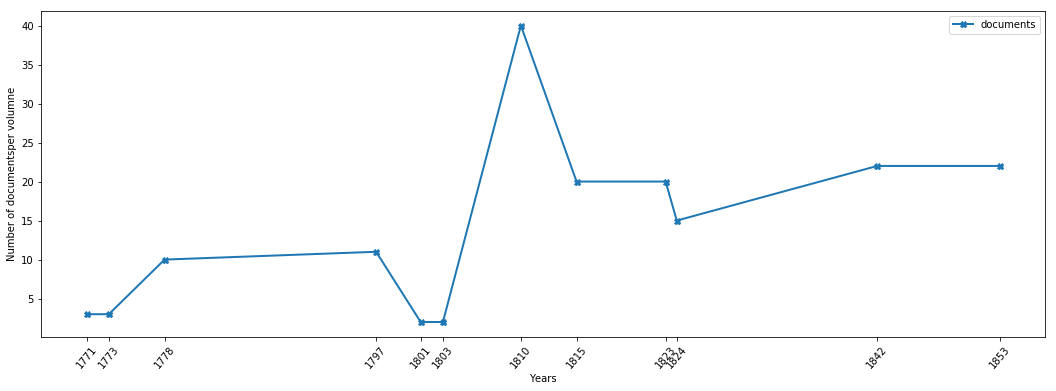

In [9]:
#Plot the variation of number of documents per volumme 
num_documents, doc_years = plot_norm(norm_publication, "documents")


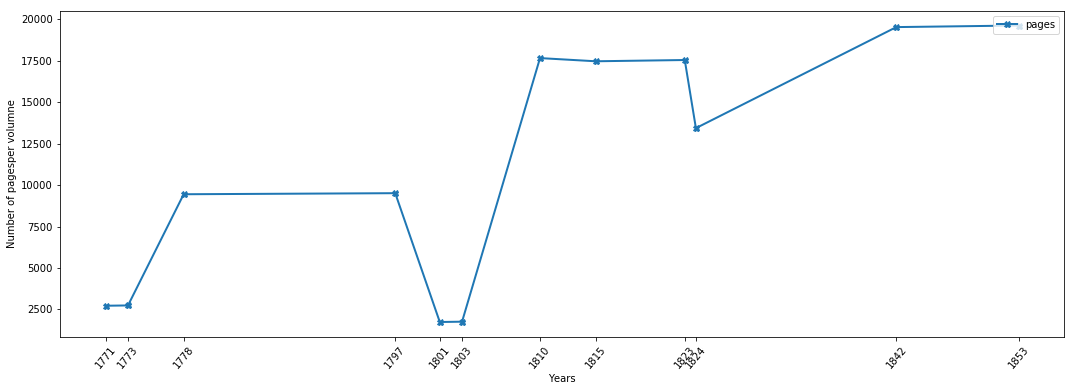

In [10]:
#Plot the variation of number of pages per volumme 
num_pages, pages_years = plot_norm(norm_publication, "pages")

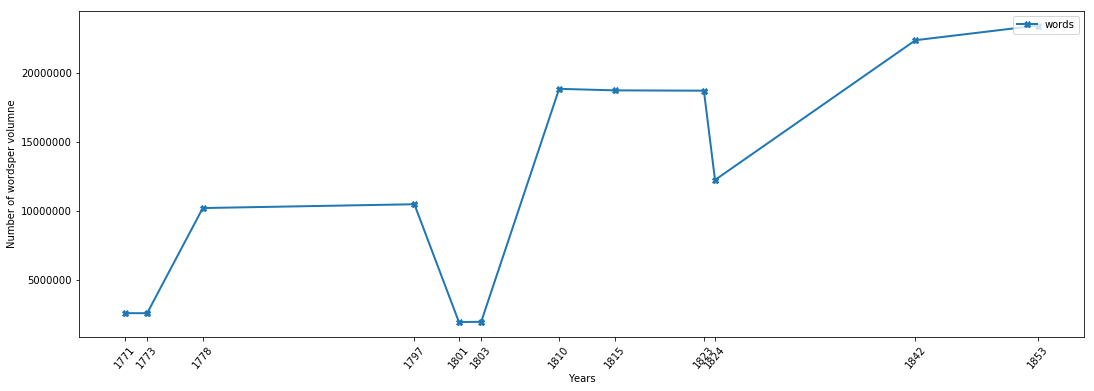

In [11]:
#Plot the variation of number of words per volumme 
num_words, words_years = plot_norm(norm_publication, "words")

And now we are going to visualize in the same figure the previous frequencies [documents| pages| words], by ploting two frequencies together each time. Notice that each frequency has a different scale 

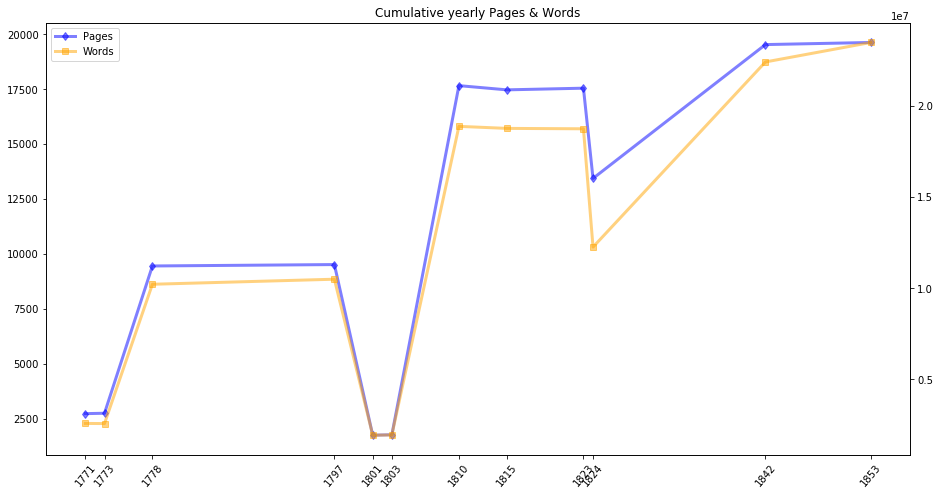

In [12]:
# Plot Pages and Words frequencies with different scales on the same plot
cumulative_plot("Pages", "Words", num_pages, num_words, words_years)

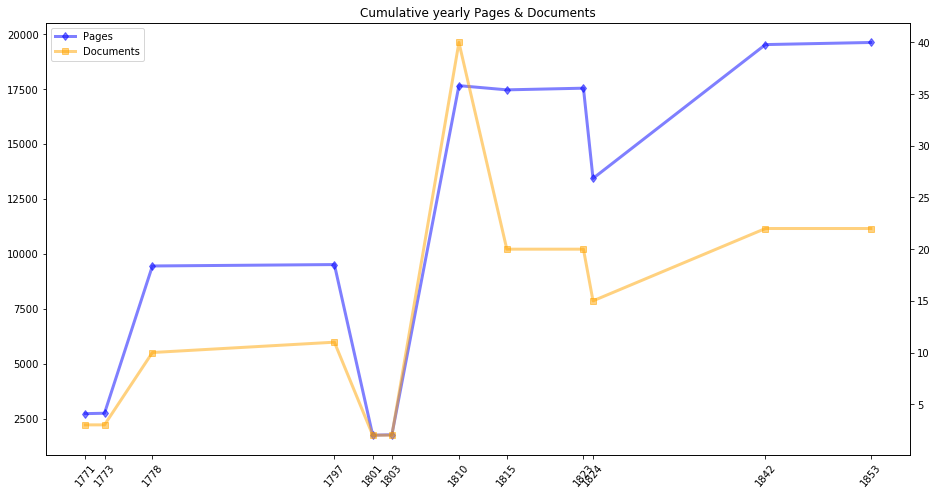

In [13]:
# Plot Pages and Documents frequencies with different scales on the same plot
cumulative_plot("Pages", "Documents", num_pages, num_documents, doc_years)

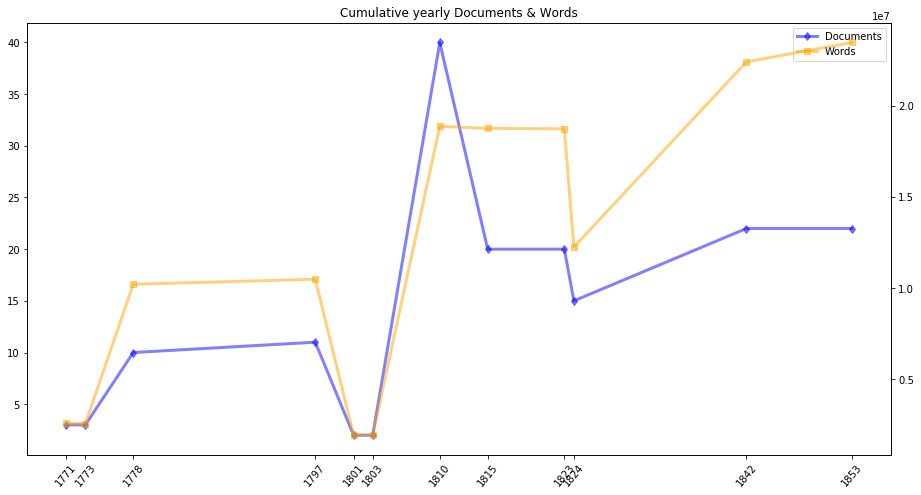

In [14]:
# Plot Documents and Words frequencies with different scales on the same plot
cumulative_plot("Documents", "Words", num_documents, num_words, words_years)

## 2. Exploring in which years were pubished each editions

We have noticed that an eddition could be published across years (including suplements).
For that reason, we have run a query, called **inventory_per_year**, 
which aggregates per year the the title and ediditon of each document.

( Query: spark-submit --py-files defoe.zip defoe/run_query.py nls_updated.txt nls defoe.nls.queries.inventory_per_year -r results_inventory_per_year -n 324 )

The results of this query can be found at this repository:   results_NLS/results_inventory_per_year

Now, we are going to calculate for each of the eight edditions, the years in which were published.

In [15]:
query_results=read_query_results('results_inventory_per_year')
list_editions={"1st":["first", "First"], "2nd":["second", "Second"],\
               "3rd":["third", "Third"],\
               "4th":["fourth", "Fourth"], \
               "5th":["fifth","Fifth"], "6th":["sixth","Sixth"],\
               "7th":["seventh", "Seventh"], "8th":["eighth", "Eighth"]} 
edition_year= {}
for year in query_results:
        for element in query_results[year]:
            for ed in list_editions:
                for ed_versions in list_editions[ed]:
                    if (ed_versions in element[1]) or (ed_versions in element[0]):
                        if ed not in edition_year:
                            edition_year[ed] = set()
                        edition_year[ed].add(year)
                                       
                        
for element in sorted(list(edition_year)):
    print ("%s edition was published on years: %s" %(element, sorted(list(edition_year[element]))))


1st edition was published on years: [1771, 1773]
2nd edition was published on years: [1778]
3rd edition was published on years: [1797, 1801, 1803]
4th edition was published on years: [1810, 1824]
5th edition was published on years: [1815, 1824]
6th edition was published on years: [1823, 1824]
7th edition was published on years: [1842]
8th edition was published on years: [1853]


Important: On 1824, we got 15 documents, which are supplements to the fourth, fifth and sixth editions. 

## 3. Distribution of topics over time

### 3. 1 Scottish Philosophers

We count the total number of words per year, and then count total instances of each phylosopher in it. Finally, we **plot normalised frequency** (by words) on a graph (x axis is years), to see whether it is a thing that is becoming more or less popular with time. All the words (query's search terms and encyclopaedia) have been normalized (lower case, and remove everything that is not a letter) and lemmatized (reduces the word-forms to linguistically valid lemmas). 

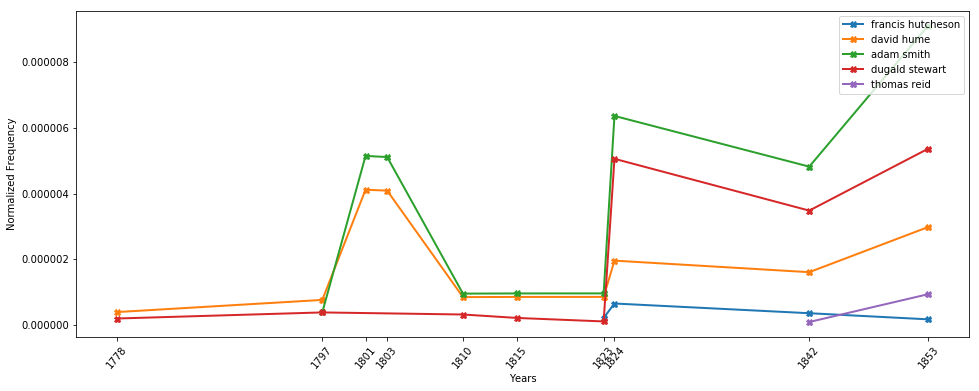

In [16]:
taxonomy= ['francis hutcheson', 'david hume', 'adam smith', 'dugald stewart', 'thomas reid']
query_results=read_query_results('results_ks_philosophers')

freq_count_lem=freq_count(query_results)
normalize_freq(norm_publication, freq_count_lem, taxonomy)

### Without normalising - Visualising the raw frequencies 

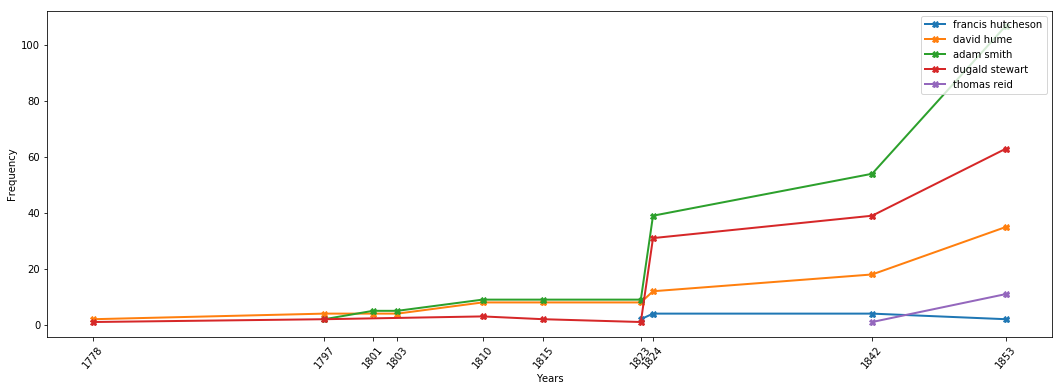

In [17]:
plot_freq_count(freq_count_lem, taxonomy)

In [18]:
# Exploring adam smith
sorted(freq_count_lem['adam smith'].items())

[(1797, 2),
 (1801, 5),
 (1803, 5),
 (1810, 9),
 (1815, 9),
 (1823, 9),
 (1824, 39),
 (1842, 54),
 (1853, 107)]

### 3.2  Scottish Cities

We count the total number of words per year, and then count total instances of each city in it. Later we **plot normalised frequency** (by words) on a graph (x axis is years).  All the words (query's search terms and encyclopaedia) have been normalized (lower case, and remove everything that is not a letter) and lemmatized (reduces the word-forms to linguistically valid lemmas). 

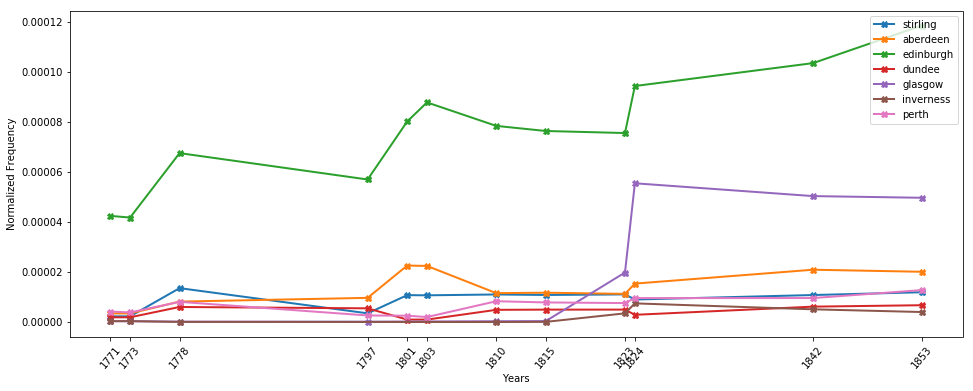

In [19]:
taxonomy= ['stirling', 'aberdeen', 'edinburgh', 'dundee', 'glasgow', 'inverness', 'perth']
query_results=read_query_results('results_ks_cities')

freq_count_lem=freq_count(query_results)
normalize_freq(norm_publication, freq_count_lem, taxonomy)

### Without normalising - Visualising the raw frequencies

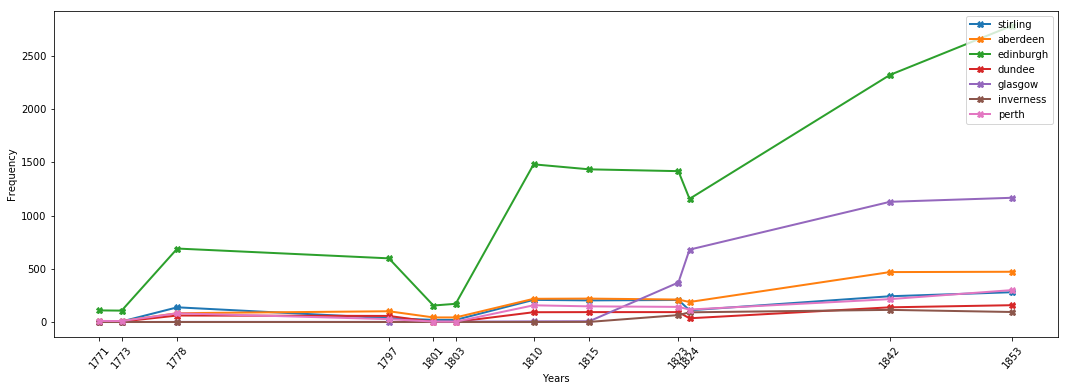

In [20]:
plot_freq_count(freq_count_lem, taxonomy)

In [21]:
# Exploring Edinburgh
sorted(freq_count_lem['edinburgh'].items())

[(1771, 110),
 (1773, 108),
 (1778, 691),
 (1797, 599),
 (1801, 156),
 (1803, 172),
 (1810, 1482),
 (1815, 1435),
 (1823, 1418),
 (1824, 1158),
 (1842, 2322),
 (1853, 2786)]

### 3.3 Sports

We count the total number of words per year, and then count total instances of each sport in it. Later we **plot normalised frequency** (by words) on a graph (x axis is years).  In this query, we havent used the lemmatization preprocess, just **normalization** (lower case, and remove everything that is not a letter).

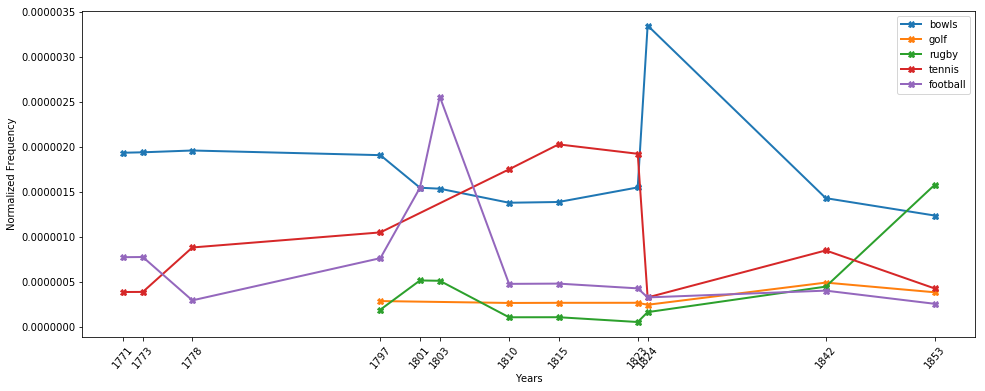

In [22]:
taxonomy= ['bowls', 'golf', 'rugby', 'tennis', 'football', 'shinty', 'real tennis', 'lawn bowls', 'garden bowls']
query_results=read_query_results('results_ks_sports_normalize')

freq_count_norm=freq_count(query_results)
normalize_freq(norm_publication, freq_count_norm, taxonomy)

### Without Normalising - Visualising the  raw frequencies 

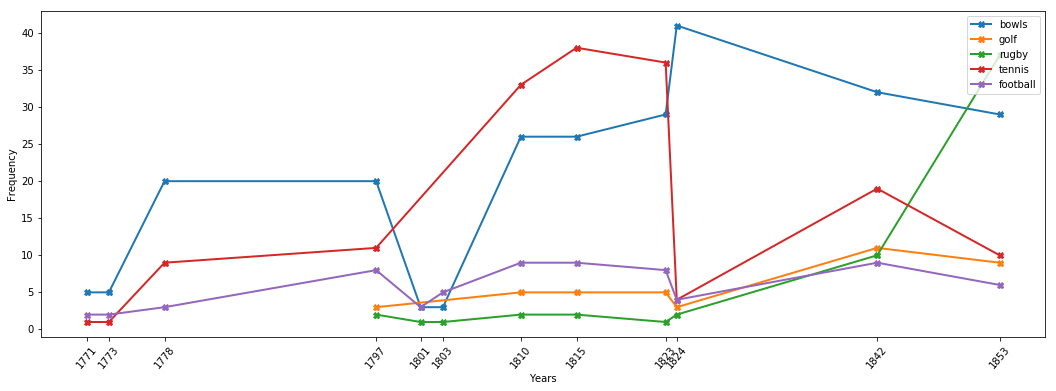

In [23]:
plot_freq_count(freq_count_norm, taxonomy)

In [24]:
# Exploring Bowling
sorted(freq_count_norm['football'].items())

[(1771, 2),
 (1773, 2),
 (1778, 3),
 (1797, 8),
 (1801, 3),
 (1803, 5),
 (1810, 9),
 (1815, 9),
 (1823, 8),
 (1824, 4),
 (1842, 9),
 (1853, 6)]

In [25]:
sorted(freq_count_norm['bowls'].items())

[(1771, 5),
 (1773, 5),
 (1778, 20),
 (1797, 20),
 (1801, 3),
 (1803, 3),
 (1810, 26),
 (1815, 26),
 (1823, 29),
 (1824, 41),
 (1842, 32),
 (1853, 29)]

### 3.4. Animals

We count the total number of words per year, and then count total instances of each aninal in it. Later we **plot normalised frequency** (by words) on a graph (x axis is years). All the words (query's search terms and encyclopaedia) have been normalized (lower case, and remove everything that is not a letter) and lemmatized (reduces the word-forms to linguistically valid lemmas). 

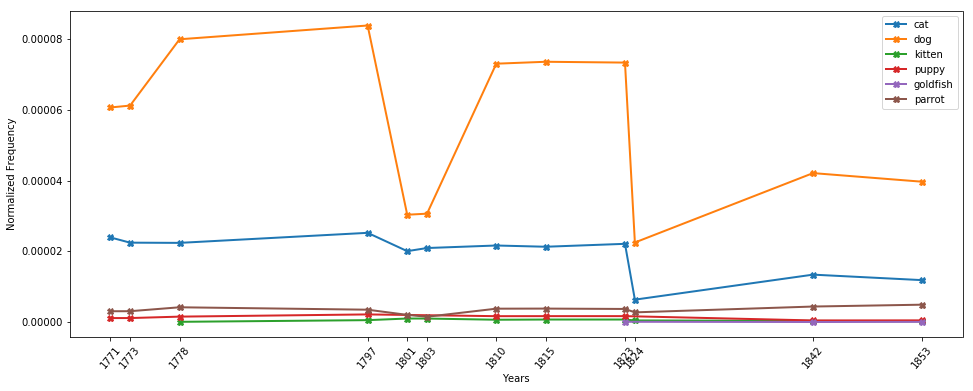

In [26]:
taxonomy= ['cat','dog', 'kitten', 'puppy', 'goldfish', 'parrot']
query_results=read_query_results('results_ks_animal')

freq_count_lem=freq_count(query_results)
normalize_freq(norm_publication, freq_count_lem, taxonomy)

### Without normalising - visualising the raw frequencies

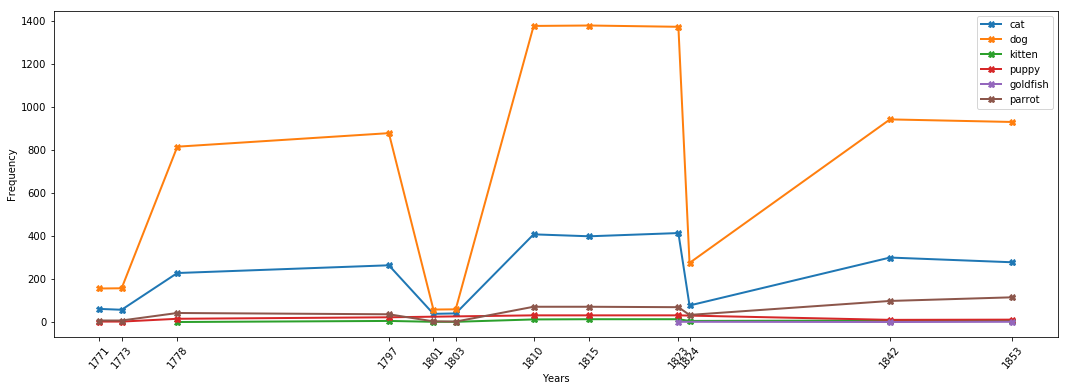

In [27]:
plot_freq_count(freq_count_lem, taxonomy)

In [28]:
#Exploring dog
sorted(freq_count_lem['dog'].items())

[(1771, 157),
 (1773, 158),
 (1778, 817),
 (1797, 880),
 (1801, 59),
 (1803, 60),
 (1810, 1379),
 (1815, 1381),
 (1823, 1375),
 (1824, 276),
 (1842, 944),
 (1853, 932)]